In [247]:
from processing_functions import *
%matplotlib inline
import warnings

warnings.filterwarnings("ignore")


In [248]:
# reading datasets
personal_data = pd.read_csv('./dataset/Ovarian/ovar_data_mar22_d032222.csv')
screen_data = pd.read_csv('./dataset/Ovarian/Screening/ovar_screen_data_mar22_d032222.csv')
screen_abnorm_data = pd.read_csv('./dataset/Ovarian/Screening Abnormalities/ovar_scrsub_data_mar22_d032222.csv')

## Preprocessing
For some of the datasets we determined some of the features to not be useful for analysis. For every dataset that includes `build` features. 

For personal dataset we removed all `ovar_` features since they are a direct result of the cancer diagnosis and should not be used predict cancer. 

For the screen data dataset it was determined that `examinerid_` features do not bring the value to the dataset since they represet 'Examiner ID made by concatentating center and exam ID for overall screen result.' and cannot be the cause of the cancer. We also drop all of the remaining

In [249]:
# Drop profy features
proxy_features_personal_dataset = [
    'fstcan_exitdays', # Days from trial entry (randomization) to first cancer diagnosis for participants with cancer, or to trial exit otherwise. Only cancers occuring during the trial are used to determine exit.
    'fstcan_exitstat', # Status of the participant at exit for first cancer incidence. Only cancers occuring during the trial are used to determine exit.
    'fstcan_exitage',
    'f_dthovar', # Is ovarian cancer the underlying cause of death? This conclusion is based on the information from the death certificate and death review.
    'f_codeath_cat', # Categorized underlying cause of death.
    'f_cancersite', # Underlying cause of death from cancer.
    'f_seer_death', # Underlying cause of death.
    'd_codeath_cat', # Categorized underlying cause of death.
    'd_dthovar', # Is Ovarian Cancer The Underlying Cause Of Death?
    'd_cancersite', # 
    'd_seer_death', # Underlying cause of death.
    'ph_ovar_muq', # Did the participant have a personal history of ovarian/ft/pt cancer prior to MUQ analysis entry? 
    'ph_ovar_sqx', # 
    'entrydays_muq', # 
    'ph_ovar_dhq', # 
    'dth_days', # 
    'bq_compdays',
    'bq_adminm',
    'bq_returned',
    'ssmokea_f',
    'orem_fyro',
    'arm',
    'sex',
    'rndyear',
    ]

proxy_features_screen_dataset = [
    'QAMETHOD',
    'tvudays_pvis1',
    'tvudays_pvis2',
    'tvudays_pvis3',
    # 'tvures_qvis1',
    # 'tvures_qvis2',
    # 'tvures_qvis3',
    # 'tvures_pvis3',  # It is completely missing for non-cancer patients
    'tvu_days',
    'tvu_assess_days_q',
    'medcomp', # 
    'physid',
    'detl_q',
    'detr_q',
    'ca125_src', # 
    'ca125_days', # 
    'ca125ii_src', # '
    'ca125_level',
    'ca125i_assess_days',
    'ca125ii_assess_days',
]

proxy_features_abnorm_dataset = ['VISIT', 'side', 'sbcd', 'source']

personal_data = personal_data.drop(proxy_features_personal_dataset, axis=1)
screen_data = screen_data.drop(proxy_features_screen_dataset, axis=1)
screen_abnorm_data = screen_abnorm_data.drop(proxy_features_abnorm_dataset, axis=1)

# Remove all ovar_ features
personal_data = remove_featues_startswith(personal_data, ['ovar_', 'mortality', 'reconsent', 'is_dead', 'build', 'biopolink', 'ca125_', 'tvu', 'entrydays', 
                                                          'entryage'
                                                          ], ['ovar_cancer', 'ovar_cancer_diagdays'])

# Remove all inad_ and examinerid_ and build_ features
screen_data = remove_featues_startswith(screen_data, ['inad_', 'examinerid', 'build', 'tvures_'])

# Drop not useful cols and convert categorical into numerical in screen abnormalities
screen_abnorm_data = remove_featues_startswith(screen_abnorm_data, ['build'])

Number of ovar_ cols: 50
['ovar_reasfoll', 'ovar_reassurv', 'ovar_reassymp', 'ovar_reasoth', 'ovar_cancer', 'ovar_intstat_cat', 'ovar_annyr', 'ovar_cancer_site', 'ovar_stage', 'ovar_stage_7e', 'ovar_stage_t', 'ovar_stage_n', 'ovar_stage_m', 'ovar_clinstage', 'ovar_clinstage_7e', 'ovar_clinstage_t', 'ovar_clinstage_n', 'ovar_clinstage_m', 'ovar_pathstage', 'ovar_pathstage_7e', 'ovar_pathstage_t', 'ovar_pathstage_n', 'ovar_pathstage_m', 'ovar_grade', 'ovar_topography', 'ovar_morphology', 'ovar_behavior', 'ovar_histtype', 'ovar_exitstat', 'ovar_exitage', 'ovar_seer', 'ovar_cancer_first', 'ovar_curative_surg', 'ovar_curative_chemo', 'ovar_primary_trt', 'ovar_num_heslide_imgs', 'ovar_has_deliv_heslide_img', 'ovar_exitdays', 'ovar_primary_trt_days', 'ovar_cancer_diagdays', 'ovar_mra_stat0', 'ovar_mra_stat1', 'ovar_mra_stat2', 'ovar_mra_stat3', 'ovar_mra_stat4', 'ovar_mra_stat5', 'ovar_eligible_bq', 'ovar_eligible_sqx', 'ovar_eligible_dhq', 'ovar_eligible_dqx']
Number of mortality cols: 3
['m

In [250]:
print_records_vs_unique(personal_data, 'plco_id', 'personal')
# Check the number of people with cancer
personal_data_cancer = personal_data[personal_data['ovar_cancer']==1]
print(f"Num of patients with cancer: {len(personal_data_cancer)}")
# Check the number of people without cancer
personal_data_no_cancer = personal_data[personal_data['ovar_cancer']==0]
print(f"Num of patients without cancer: {len(personal_data_no_cancer)}")

Num of records in personal dataset: 78209
Num of unique plco_id in personal dataset: 78209
Num of patients with cancer: 613
Num of patients without cancer: 77596


In [251]:
screen_abnorm_data.columns

Index(['study_yr', 'solid', 'sepst', 'cyst', 'cystw', 'echo', 'maxdi', 'volum',
       'plco_id'],
      dtype='object')

In [252]:
# Convert discrete float columns to floats with lower number of bytes
personal_data = convert_numeric_to_float16(personal_data)
screen_data = convert_numeric_to_float16(screen_data)
screen_abnorm_data = convert_numeric_to_float16(screen_abnorm_data)

## Merging data into features and mean imputing

Deciding which patients will be in training vs test set to learn the mean imputation parameters.

Mean imputation: https://www.kaggle.com/general/226554

To predict whether person will get cancer in the next 1, 3, 5, 10 years we need to determine what feature describes when person got cancer. In our case that features is `ovar_cancer_diagdays`. We are going to use that feature in the following manner: we are going to have a sliding window to determine whether the person gets cancer withing the period of that window. Then, we are going to slide that window by one year and determine a new batch of people who are going to get cancer in that window and so on. For each of the features that are measured across multiple years we only going to use a record that is at the beginning of the interval. 

Since `ovar_cancer_diagdays` is described in days and we are concerned about the years when people will get cancer we need to convert this feature into years. Since people got cancer from year 1 to year 19, we are going to bucket it into 19 buckets corresponding to year when person got cancer. 

In [253]:
ovar_cancer_diagdays_range = personal_data['ovar_cancer_diagdays'].max() / 365
print(f'Max value of ovar_cancer_diagdays in years is {ovar_cancer_diagdays_range}')


Max value of ovar_cancer_diagdays in years is 18.893150684931506


In [254]:
personal_data['ovar_cancer_years'] = pd.cut(personal_data['ovar_cancer_diagdays'], bins=19, labels=list(range(0, 19)), include_lowest=True)
personal_data['ovar_cancer_years'] = pd.to_numeric(personal_data['ovar_cancer_years'])

We can also set every healthy persons '`ovar_cancer_years`' to 100 so that it is easier to filter them

In [255]:
personal_data['ovar_cancer_years'] = personal_data['ovar_cancer_years'].fillna(100)

When merging abnormalities dataset we are going to keep each record for each `study_yr`, select the latest `VISIT` if there are multiple and take the largest value of each column over all of the remaining records. 

See below what I found about CA125 vs CA125ii......it sounds like we should actually just be using CA125ii.  When they switched tests, they actually used the new test (CA125ii) to re-test the frozen samples from all of the patients who had the original test.  So CA125ii should be present for all patients who had testing, and CA125 is only left in as a variable for a perspective on what patients were initially told at that time.


So I think that the only variable we need to use for this tumor marker is ca125ii_level0-5, which is from the ovary person dataset, and we can disregard values for ca125_level0-5.


CA-125 ASSAYS, VERSIONS 1 AND 2 

When the trial began, PLCO used the first version of the assay for all CA-125 exams. On October 1, 1995, CA-125II became available and the protocol was switched to use this for all subsequent screens. A few years after this transition, all of the original samples were re-assayed using version two. So, use CA125_LEVEL0-5 to get the result of a screen from a clinical perspective of what the participant was told following their screening visit. Use CA125II_LEVEL0-5 to get the result of a screen from an epidemiologic perspective, with all values coming from the same assay. 


Since ca125ii only present in the personal dataset, I only kept the feature that describes the level of ca125ii for a year that is a baseline year (for the windown when they got cancer) of people when merging data.


`TODO:` some features in the person dataset represent observations over multiple years

`TODO:` bucket age by 3 or 5 years

In [256]:
# drop non-cancer records without screen records
personal_filtered = personal_data
condition = (personal_data['plco_id'].isin(screen_data['plco_id'])) | (personal_data['ovar_cancer'] == 1)
personal_filtered = personal_filtered[condition]

In [257]:
personal_filtered[personal_filtered['ovar_cancer_years']<50][['ovar_cancer_years']].describe()

,ovar_cancer_years
count,613.000000
mean,7.075041
std,4.791153
min,0.000000
25%,3.000000
50%,7.000000
75%,11.000000
max,18.000000


In [258]:
personal_filtered = personal_filtered.drop(['ovar_cancer_diagdays'], axis=1)
merged_df = merge_data_over_years(personal_filtered, screen_data, screen_abnorm_data, screen_join='left', abrorm_join='left')


In [259]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336206 entries, 0 to 78166
Columns: 173 entries, ovar_cancer to was_screened
dtypes: float16(165), float64(5), int64(2), object(1)
memory usage: 128.9+ MB


In [260]:
# Convert discrete float columns to floats with lower number of bytes
# Maybe discretise some
# merged_summary = summarize_features(merged_df)
# cols_unique_under_90 = merged_summary[merged_summary['unique count'] < 90].index
# merged_df[cols_unique_under_90] = merged_df[cols_unique_under_90].astype(np.float16)

In [261]:
# Drop features that are 100% missing
# merged_df = drop_cols_missing_percentage(100, merged_df, 'merged_df')

In [262]:
# get_cols_missing_percentage(50, merged_df, 'imputed_df', show_missing=True)

In [263]:
screen_abnorm_data.columns

Index(['study_yr', 'solid', 'sepst', 'cyst', 'cystw', 'echo', 'maxdi', 'volum',
       'plco_id'],
      dtype='object')

Impute data for patient with the most recent value for a feature if at all present

In [264]:
[col for col in merged_df.columns if 'study_yr' in col]

['study_yr']

In [265]:
sum(merged_df['study_yr'].isnull())

185217

In [266]:
len(merged_df)

336206

In [267]:
merged_df['study_yr'] = merged_df['study_yr'].fillna(-1)

In [307]:
def use_most_recent(df, keep_last_on_col, col_id, on_cols):
    for col in on_cols:
        sorted_df = df[df[col].notnull()]
        sorted_df = sorted_df.sort_values(by=keep_last_on_col)
        impute_values = sorted_df.drop_duplicates(col_id, keep='last')
        impute_values = impute_values[[col_id, col]]
        # print(impute_values)
        df = df.set_index(col_id).combine_first(impute_values.set_index(col_id)).reset_index()
    return df

screen_data_cols_fill_last = ['detl_p', 'detr_p', 'lvol_p', 'rvol_p', 'lvol_q', 'rvol_q',
       'lantero_p', 'lantero_q', 'llong_p', 'llong_q', 'ltran_p', 'ltran_q',
       'rantero_p', 'rantero_q', 'rlong_p', 'rlong_q', 'rtran_p', 'rtran_q',
       'tvu_ref', 'phycons', 'tvu_result', 'ca125_result', 'ovar_result',
       'ovcyst_solidr', 'ovcyst_outliner', 'ovcyst_solidl', 'ovcyst_outlinel',
       'ovcyst_solid', 'ovcyst_outline', 'ovcyst_diamr', 'ovcyst_diaml',
       'ovcyst_diam', 'ovcyst_volr', 'ovcyst_voll', 'ovcyst_vol',
       'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr',
       'ovcyst_suml', 'ovcyst_sum', 'ovary_diam', 'ovary_diamr', 'ovary_diaml',
       'ovary_volr', 'ovary_voll', 'ovary_vol', 'visl', 'visr', 'visboth',
       'viseith', 'numcystl', 'numcystr', 'numcyst']

screen_abnorm_data_fill_last = ['solid', 'sepst', 'cyst', 'cystw', 'echo', 'maxdi', 'volum']
last_propagated_df = use_most_recent(merged_df, 'study_yr', 'plco_id', screen_data_cols_fill_last)
last_propagated_df = use_most_recent(last_propagated_df, 'study_yr', 'plco_id', screen_abnorm_data_fill_last)

# get_cols_missing_percentage(0, merged_df[screen_data_cols_fill_last], 'merged_df', show_missing=True)
# get_cols_missing_percentage(0, last_propagated_df[screen_data_cols_fill_last], 'last_propagated_df', show_missing=True)

# get_cols_missing_percentage(0, merged_df[screen_abnorm_data_fill_last], 'merged_df', show_missing=True)
# get_cols_missing_percentage(0, last_propagated_df[screen_abnorm_data_fill_last], 'last_propagated_df', show_missing=True)

['detl_p', 'detr_p', 'lvol_p', 'rvol_p', 'lvol_q', 'rvol_q', 'lantero_p', 'lantero_q', 'llong_p', 'llong_q', 'ltran_p', 'ltran_q', 'rantero_p', 'rantero_q', 'rlong_p', 'rlong_q', 'rtran_p', 'rtran_q', 'tvu_ref', 'phycons', 'tvu_result', 'ca125_result', 'ovar_result', 'ovcyst_solidr', 'ovcyst_outliner', 'ovcyst_solidl', 'ovcyst_outlinel', 'ovcyst_solid', 'ovcyst_outline', 'ovcyst_diamr', 'ovcyst_diaml', 'ovcyst_diam', 'ovcyst_volr', 'ovcyst_voll', 'ovcyst_vol', 'ovcyst_morphr', 'ovcyst_morphl', 'ovcyst_morph', 'ovcyst_sumr', 'ovcyst_suml', 'ovcyst_sum', 'ovary_diam', 'ovary_diamr', 'ovary_diaml', 'ovary_volr', 'ovary_voll', 'ovary_vol', 'visl', 'visr', 'visboth', 'viseith', 'numcystl', 'numcystr', 'numcyst']
['solid', 'sepst', 'cyst', 'cystw', 'echo', 'maxdi', 'volum']


In [308]:
last_propagated_df = last_propagated_df.drop('study_yr', axis=1)

In [309]:
original_missing = get_cols_missing_percentage(0, merged_df, 'merged_df', False)[['column_name', 'percent_missing']]

The table of features missing over 0 percentage: 


In [310]:
after_prop_missing = get_cols_missing_percentage(0, last_propagated_df, 'asdf', False)[['column_name', 'percent_missing']]

The table of features missing over 0 percentage: 


In [311]:
missing_df = original_missing.merge(after_prop_missing, suffixes=['_before_propagation', '_after_propagation'], on='column_name')

In [312]:
print(len(merged_df[merged_df['ca125ii_level'].notnull()]))
print(len(last_propagated_df[last_propagated_df['ca125ii_level'].notnull()][['ca125ii_level']]))

150578
150578


## Merging Datasets

`TODO:` should we dismiss people who do not have records in screen dataset. Abnormalities dataset? Run tests on all of the combinations of merges and imputations? 

I realized that I was doing labeled mean imputation, which should not happen. So, I performed imputation after I merged cancer and no_cancer datasets back together. Without labeled mean imputation, gaussian NB and logistic regression do not perform well. 

run experiments with decision tree and remove the top feature every time. Store the depth of the tree, the efficacy of the top feature, its value, accuracy, confusion matrix

https://stackoverflow.com/questions/62819569/how-to-return-the-features-that-used-in-decision-tree-that-created-by-decisiontr

`TODO:` Run model purely on family history variables vs purely on screen variables. 

In [275]:

import xgboost as xgb

In [276]:

def feature_selection(classifier, fn, accuracy, plot_tree=False, filepath='./trees/decision_tree.png'):
    
    if plot_tree:
        cn=['no cancer', 'cancer']
        if classifier.__class__.__name__ == 'DecisionTreeClassifier':
            fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=3000)
            tree.plot_tree(classifier,
                        max_depth=5,
                feature_names = fn, 
                class_names=cn,
                filled = True)
            plt.savefig(filepath)
            # plt.show()
        if classifier.__class__.__name__ == 'XGBClassifier':
            # fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=3000)
            fig, axes = plt.subplots(nrows = 1,ncols = 1, dpi=6000)
            # plt.gcf().set_size_inches(18.5, 10.5)
            xgb.plot_tree(classifier, rankdir='LR', ax=axes)
            plt.savefig(filepath)
    feature_importances = pd.DataFrame(classifier.feature_importances_,
                        index = fn,
                        columns=['importance']).sort_values('importance', 
                                                            ascending=False)
    feature_importances['column_name'] = feature_importances.index
    feature_importances = feature_importances[['column_name', 'importance']]
    # TODO: boundary and confusion matrix
    tree_depth = None
    if classifier.__class__.__name__ == 'DecisionTreeClassifier':
        tree_depth = classifier.tree_.max_depth
    if classifier.__class__.__name__ == 'XGBClassifier':
        tree_depth = classifier.max_depth
    top_feature_stats = {
        'top_feature': feature_importances.iloc[0]['column_name'],
        # 'boundary': 0,
        'num_features_used': len(feature_importances[feature_importances['importance'] > 0]),
        'importance': round(feature_importances.iloc[0]['importance'], 3),
        'tree_depth': tree_depth,
        'accuracy': accuracy,
        # 'precision': precision,
        # 'recall':    recall,
        # 'f1-score':  f1,
    }
    return top_feature_stats, feature_importances



In [277]:
def get_cv_scores(classifier, k_fold_lambdas):
    cv_scores = []
    # pipeline = make_pipeline(StandardScaler(), classifier)
    df_feature_importance_tree = None
    for k, k_fold_lambda in enumerate(k_fold_lambdas):
        X_train, X_test, y_train, y_test = k_fold_lambda()
        # pipeline.fit(X_train_cv, y_train_cv)
        # score = pipeline.score(X_test_cv, y_test_cv)
        auc, accuracy, report = run_classifier(classifier, X_train, X_test, y_train, y_test, show_graph=False)
        cv_scores.append(report)
        # print(f'Fold: {k+1}, Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}, Auc: {auc:.3f}')
        # Decision Tree feature selection
        if classifier.__class__.__name__ in ['DecisionTreeClassifier', 'XGBClassifier']:
            fn=X_train.columns
            top_feature_stats, feature_importances = feature_selection(classifier, fn, accuracy, plot_tree=False)
            feature_importances = feature_importances[feature_importances['importance'] > 0]
            if df_feature_importance_tree is not None:
                df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='column_name', how='outer', suffixes=[f'_tiral_{k}', f'_tiral_{k+1}'])
            else:
                df_feature_importance_tree = feature_importances
    cv_scores = pd.concat(cv_scores)
    cv_scores = cv_scores.reset_index()
    cv_scores = cv_scores.drop('index', axis=1)
    measures_df = cv_scores.describe().T[['mean', 'std', 'min', 'max']]
    print('\n\nCross-Validation measures:')
    print_df(measures_df)
    if classifier.__class__.__name__ in ['DecisionTreeClassifier', 'XGBClassifier']:
        # Mean of feature importance over trials
        df_feature_importance_mean = df_feature_importance_tree.drop('column_name', axis=1)
        df_feature_importance_mean = df_feature_importance_mean.T
        df_feature_importance_mean.columns = df_feature_importance_tree['column_name']
        df_feature_importance_mean = df_feature_importance_mean.astype('float')
        df_feature_importance_mean_describe = df_feature_importance_mean.describe().T
        df_feature_importance_mean_describe.sort_values('mean', ascending=False, inplace=True)
        # print(df_feature_importance_mean_describe.columns)
        df_feature_importance_mean_describe = df_feature_importance_mean_describe[['count', 'mean']]
        # print_df(df_feature_importance_mean_describe)
    df_feature_importance_mean_describe = df_feature_importance_mean_describe.merge(missing_df, on='column_name')
    return cv_scores, measures_df, df_feature_importance_mean_describe


`TODO:` https://machinelearningmastery.com/visualize-gradient-boosting-decision-trees-xgboost-python/

In [278]:
from scipy.spatial import distance


In [279]:
def scale_features(df):
    sc = StandardScaler()
    df_scaled = df.copy()
    df_scaled = sc.fit_transform(df_scaled)
    df_scaled = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)
    return df_scaled

In [321]:
def get_nearest_neighbors(df1, df2, top=5):
    df1 = df1.drop_duplicates()
    df2 = df2.drop_duplicates()
    df1 = scale_features(df1)
    df2 = scale_features(df2)
    euclidean_distances = []
    indexes = []
    for i in range(len(df1)):
        row1 = df1.iloc[i]
        distances = []
        for j, row2 in df2.iterrows():
            distances.append((j, distance.euclidean(row1, row2)))
        distances = sorted(distances, key=lambda x: x[1], reverse=False)[:top]
        distances = pd.DataFrame(distances, columns=['index', 'distance'])
        indexes.append((distances['index'].to_list()))
        euclidean_distances.append(distances['distance'].to_list())
    return euclidean_distances, indexes

def get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0):
    # Insert predicted class and its likelihood
    y_pred = classifier.predict(X_test)
    y_prob = classifier.predict_proba(X_test)[:,1]
    X_test_mismatch = X_test.copy()
    X_test_mismatch[label] = y_test
    X_test_mismatch[f'{label}_pred'] = y_pred
    X_test_mismatch[f'{label}_prob'] = y_prob
    X_test_mismatch = X_test_mismatch.drop_duplicates()
    X_test_mismatch = X_test_mismatch[X_test_mismatch[label] != X_test_mismatch[f'{label}_pred']]
    
    X_test_high_conf = X_test_mismatch[(X_test_mismatch[f'{label}_prob'] < 0.2) | (X_test_mismatch[f'{label}_prob'] > 0.8)]
    X_test_high_conf = X_test_high_conf[X_test_high_conf[f'{label}_pred'] == label_val]
    
    # Select 5 nearest neightbors 
    X_train[label] = y_train
    X_train_filtered = X_train[X_train[label] == 1].drop(label, axis=1)
    # X_test_high_conf = X_test.loc[X_test_high_conf.index, :]
    # Calculated euclidean distances
    distances, indices = get_nearest_neighbors(X_test.loc[X_test_high_conf.index, :], X_train_filtered)
    fp_mismatches = []
    X_train[f'{label}_pred'] = -1
    X_train[f'{label}_prob'] = -1
    X_train = X_train.drop_duplicates()
    # print_df(X_train)
    for i in range(len(X_test_high_conf)):
        idx = indices[i]
        missed_record = X_test_high_conf.iloc[[i], :]
        missed_record['distance'] = 0
        close_records = X_train.loc[idx, :]
        close_records['distance'] = distances[i]
        fp_mismatches.append((missed_record, close_records))
    return fp_mismatches

In [281]:
def run_classifiers(classifiers, df, label, strategy='median', drop_n_features = 1, num_folds=10, cv=False, plot_tree=False):
    df_feature_importance_tree = None
    df_top_feature_importances = []
    for i in range(drop_n_features):
        
        train_test_lambda, k_fold_lambdas = process_and_impute_for_label_kfold(df, label, strategy, n_max_per_class=10000, num_folds=num_folds)
        X_train, X_test, y_train, y_test = train_test_lambda()
        auc_dict = {}
        accuracy_dict = {}
        top_feature_importance = []
        for classifier_type, classifier in classifiers.items():
            # Cross Validation
            if cv:
                cv_scores, measures_df, df_feature_importance_mean_describe = get_cv_scores(classifier, k_fold_lambdas)
                cv_scores.to_csv(f'./cv_scores/cv_scores_for_{classifier_type}_{label}.csv')
                measures_df.to_csv(f'./cv_scores/cv_stats_for_{classifier_type}_{label}.csv')
                if classifier_type in ['DecisionTreeClassifier', 'XGBClassifier']:
                    df_feature_importance_mean_describe.to_csv(f'./feature_importance/feature_importance_mean_{classifier_type}_{label}__{num_folds}_trials.csv')

            # Test classifier
            print(classifier_type)
            auc, accuracy, report = run_classifier(classifier, X_train, X_test, y_train, y_test)

            # Decision Tree feature selection
            if classifier_type in ['DecisionTreeClassifier', 'XGBClassifier']:
                fn=X_train.columns
                top_feature_stats, feature_importances = feature_selection(classifier, fn, accuracy, plot_tree=plot_tree,
                                                                                         filepath=f'./trees/decision_tree_for_{classifier_type}_{label}.png')
                df_top_feature_importances.append(top_feature_stats)
                top_feature_importance.append(feature_importances.iloc[0]['column_name'])
                feature_importances = feature_importances[feature_importances['importance'] > 0]
                if df_feature_importance_tree is not None:
                    df_feature_importance_tree = df_feature_importance_tree.merge(feature_importances, on='column_name', how='outer', suffixes=[f'_tiral_{i}', f'_tiral_{i+1}'])
                else:
                    df_feature_importance_tree = feature_importances
            auc_dict[classifier_type] = auc
            accuracy_dict[classifier_type] = accuracy
            
            fp_mismatches = get_high_confidence_errors(classifier, X_train, X_test, y_train, y_test, label, label_val=0)
        # df = df.drop(top_feature_importance, axis=1)

    return df_top_feature_importances, df_feature_importance_tree, fp_mismatches




`TODO:` At what point they were misclassified (e.g. at what point they diverge compared to the similar point with different prediction.) Look at the nearest neightbors with different neightbors. 

`TODO:` try SVM or ML models

`TODO:` include the level of missingness for a particular features of a tree in order of usage.

`TODO:` turn all of this into OOP programming

Distribution of labels based on unique plco_id: 0.09615384615384616
Distribution of labels based on duplicate plco_id: 0.1761827079934747


Cross-Validation measures:
+--------------------+-----------+-------------+-----------+-----------+
|                    |      mean |         std |       min |       max |
|--------------------+-----------+-------------+-----------+-----------|
| precision__class_0 | 0.999203  | 1.40761e-05 | 0.999182  | 0.999215  |
| recall__class_0    | 0.98244   | 0.00215557  | 0.979796  | 0.984888  |
| f1-score__class_0  | 0.99075   | 0.00109866  | 0.989408  | 0.991999  |
| precision__class_1 | 0.0500506 | 0.00617087  | 0.0436927 | 0.0575673 |
| recall__class_1    | 0.538596  | 0.00784585  | 0.526316  | 0.54386   |
| f1-score__class_1  | 0.0915112 | 0.0103641   | 0.0808871 | 0.104114  |
| accuracy           | 0.981688  | 0.00215534  | 0.979057  | 0.98414   |
| auc                | 0.913081  | 0.00310658  | 0.911422  | 0.918607  |
+--------------------+--------

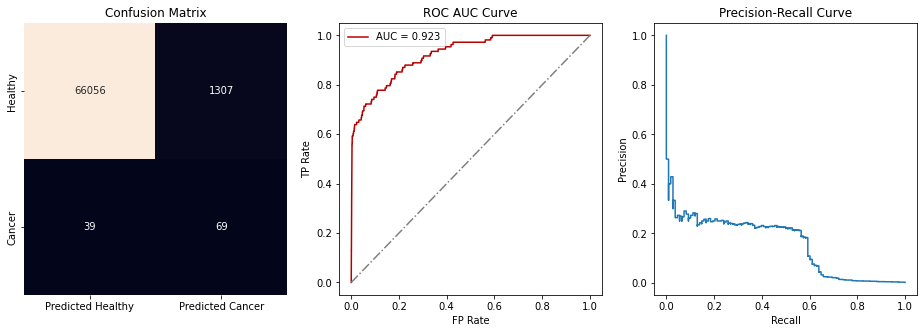

Distribution of labels based on unique plco_id: 0.18115942028985507
Distribution of labels based on duplicate plco_id: 0.2046783625730994


Cross-Validation measures:
+--------------------+-----------+------------+-----------+-----------+
|                    |      mean |        std |       min |       max |
|--------------------+-----------+------------+-----------+-----------|
| precision__class_0 | 0.998004  | 0.00011768 | 0.997846  | 0.998178  |
| recall__class_0    | 0.975553  | 0.00288499 | 0.972258  | 0.978695  |
| f1-score__class_0  | 0.986649  | 0.00144087 | 0.984963  | 0.988253  |
| precision__class_1 | 0.0879614 | 0.0075693  | 0.0779944 | 0.0985816 |
| recall__class_1    | 0.545312  | 0.0277041  | 0.507812  | 0.585938  |
| f1-score__class_1  | 0.151307  | 0.0109499  | 0.136519  | 0.166867  |
| accuracy           | 0.973715  | 0.00279798 | 0.97044   | 0.976833  |
| auc                | 0.913156  | 0.0044238  | 0.908699  | 0.919659  |
+--------------------+-----------+-------

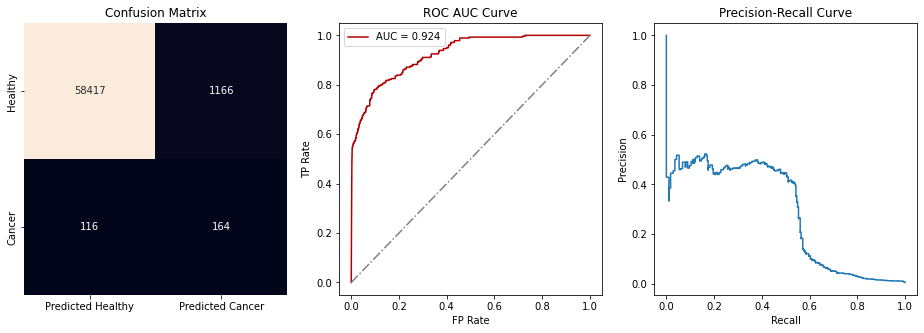

Distribution of labels based on unique plco_id: 0.18552036199095023
Distribution of labels based on duplicate plco_id: 0.18972533062054933


Cross-Validation measures:
+--------------------+----------+-------------+----------+----------+
|                    |     mean |         std |      min |      max |
|--------------------+----------+-------------+----------+----------|
| precision__class_0 | 0.996572 | 9.11863e-05 | 0.996425 | 0.996673 |
| recall__class_0    | 0.973605 | 0.00200329  | 0.971354 | 0.976313 |
| f1-score__class_0  | 0.984954 | 0.00102239  | 0.983851 | 0.986349 |
| precision__class_1 | 0.124701 | 0.00857585  | 0.116379 | 0.136901 |
| recall__class_1    | 0.527957 | 0.0126943   | 0.508065 | 0.543011 |
| f1-score__class_1  | 0.201633 | 0.0113495   | 0.189379 | 0.217559 |
| accuracy           | 0.970465 | 0.00197759  | 0.968337 | 0.973166 |
| auc                | 0.901468 | 0.00255196  | 0.898249 | 0.903797 |
+--------------------+----------+-------------+----------+----

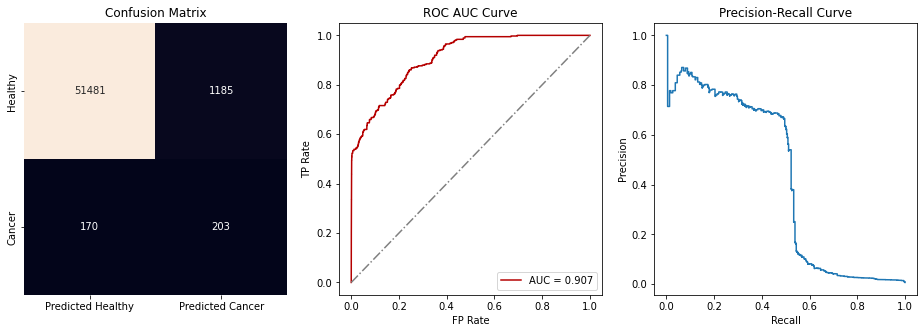

Distribution of labels based on unique plco_id: 0.20437956204379562
Distribution of labels based on duplicate plco_id: 0.21219612690564482


Cross-Validation measures:
+--------------------+----------+------------+----------+----------+
|                    |     mean |        std |      min |      max |
|--------------------+----------+------------+----------+----------|
| precision__class_0 | 0.993647 | 0.00020145 | 0.993427 | 0.993954 |
| recall__class_0    | 0.974452 | 0.00113846 | 0.972864 | 0.975799 |
| f1-score__class_0  | 0.983955 | 0.00053276 | 0.983296 | 0.984598 |
| precision__class_1 | 0.177476 | 0.00566931 | 0.171473 | 0.183835 |
| recall__class_1    | 0.469262 | 0.0172667  | 0.45082  | 0.495902 |
| f1-score__class_1  | 0.257479 | 0.00712902 | 0.248447 | 0.265143 |
| accuracy           | 0.968589 | 0.00102369 | 0.967329 | 0.969826 |
| auc                | 0.882318 | 0.00469857 | 0.877277 | 0.887792 |
+--------------------+----------+------------+----------+----------+
XGBC

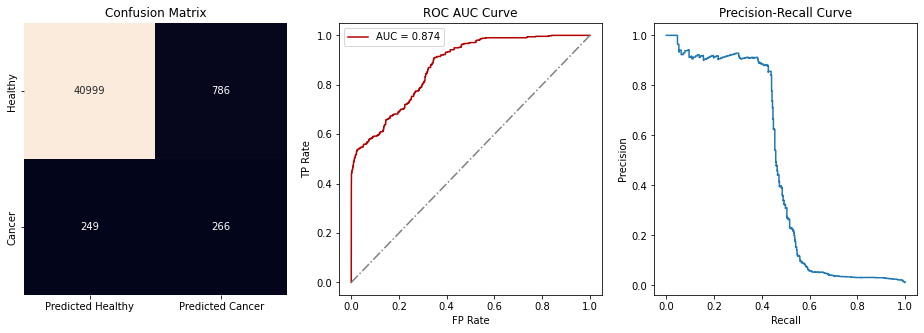

In [326]:
classifiers = {
    # 'LogisticRegression': LogisticRegression(C= 0.25, random_state= 0),
    # 'GaussianNB': GaussianNB(var_smoothing= 1e-09),
    # 'DecisionTreeClassifier': DecisionTreeClassifier(criterion= 'entropy'),
    # 'RandomForestClassifier': RandomForestClassifier(criterion= 'entropy', n_estimators= 200),
    'XGBClassifier': XGBClassifier(eval_metric= 'error', learning_rate= 0.1)
}
years = [1, 3, 5, 10]
drop_n_features = 1
cv=True
for year in years:
    label = f'cancer_in_next_{year}_years' # 'cancer_in_next_10_years', 'ovar_cancer'
    df_top_feature_importances, df_feature_importance_tree, X_test_mismatch = run_classifiers(classifiers, last_propagated_df, label, strategy='mean', cv=cv, drop_n_features = drop_n_features, num_folds=5, plot_tree=False)


`TODO:` divide them as FP and FN?

`TODO:` only keep columns with more than 1 unique value? 

In [323]:
len(X_test_mismatch)

21

In [324]:
print_df(pd.concat(X_test_mismatch[1][:2]))

+--------+-------+------------+-------------+-------+---------+-------+------------+-----------+-----------+-----------------+----------+-----------+----------+-----------+------------+------------+----------+-------------+-----------------+-----------------+--------------+------------+----------------+-----------------+----------+------------+------------+-------------+---------+-----------+---------------------+-----------+---------+---------+----------+----------+--------------+--------------+--------+--------+----------+------------+-----------------+-----------+-------------+--------------+-----------+--------------+------------+------------+--------------+----------+-------------+--------------+------------+-----------+--------+----------+-----------------------+-------------+-------------+---------+---------------------+-----------+-----------+-----------+-----------+-----------+----------+----------+-----------------+-----------+---------+-----------+---------------------+-----

`TODO:` calculate the distance between the most confident misclassification and examples of the opposite class in training data. Possibly need standardisation

In [325]:
# drop col if the feature value of patient that was misclassified does not appear in the list of feature values of patients that were classified
df = pd.concat(X_test_mismatch[1][:2])
for col in df.columns:
    if df[col].iloc[0] in df[col].iloc[list(range(1, 6))].to_list():
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)

+--------+----------+----------+------------+----------+-------------+---------+---------+--------+-------------+-------------+-----------+-----------+-----------+-----------+----------+----------+---------+--------------+---------------+-------------+--------------+---------------+------------------+-------------------+-------------------+--------------+---------------+--------------+------------+-------------+-----------+-----------+-----------+----------+-----------+------------+----------+---------+--------------+-------------------------------+-------------------------------+------------+
|        |   bmi_20 |   bmi_50 |   bmi_curr |   bq_age |   cig_years |    cyst |   cystw |   echo |   lantero_p |   lantero_q |   llong_p |   llong_q |   ltran_p |   ltran_q |   lvol_p |   lvol_q |   maxdi |   ovary_diam |   ovary_diaml |   ovary_vol |   ovary_voll |   ovcyst_diam |   ovcyst_outline |   ovcyst_outlinel |   ovcyst_outliner |   ovcyst_vol |   ovcyst_voll |   pack_years |   polyps_f

In [286]:

print_df(summary)

+-----------------------------+----------------+---------+-------------+-------------+-----------+------------+-----------+-----------+-------------+
|                             |   unique count |   count |        mean |         std |       min |        25% |       50% |       75% |         max |
|-----------------------------+----------------+---------+-------------+-------------+-----------+------------+-----------+-----------+-------------|
| ca125ii_level               |              6 |       6 |  128.5      |  165.034    |   8       |  13.75     |  36.5     | 255.75    |  355        |
| bq_age                      |              5 |       6 |   65.8333   |    6.82398  |  56       |  61.5      |  67       |  71       |   73        |
| cig_stop                    |              5 |       6 |   18.0787   |    5.88815  |   8       |  16.1043   |  19.5     |  21       |   25        |
| cig_years                   |              6 |       6 |   22.5      |   13.6198   |   0       |  

In [287]:

df = pd.concat(X_test_mismatch[4][:2])
for col in df.columns:
    if len(df[col].unique()) <= 2:
        df.drop(col,inplace=True,axis=1)
print_df(df)
summary = summarize_features(df)
print_df(summary)

+--------+-----------------+----------+-----------+-----------+----------+-----------------+--------------------+------------------+-----------+---------+---------+---------+-----------+-----------+-----------+---------+----------+------------+-----------+--------------+------------+-------------+--------------+----------+----------+------------+------------+------------+--------------+--------------+------------+----------+----------+-----------+----------+----------+-------------+-------------+-----------+-----------+-----------+-----------+-------------+-------------+-----------+-----------+-----------+-----------+-------------------+-------------------+----------------+------------------+----------------+----------------+---------------+---------------+---------------+--------------+-----------------+-----------------+----------------+---------------+---------------+--------------+--------------+---------------+---------------+--------------+--------------+-------------+---------+-

`TODO:` make spreadsheet with model performance for 1,3,5,10 years. Print out trees, top 5 features. Send models

In [288]:
ranked_df = df_feature_importance_tree.rank(method='max')
ranked_df['feature'] = df_feature_importance_tree['feature']
ranked_df = ranked_df.drop('feature', axis=1)
ranked_df = ranked_df.T
ranked_df.columns = df_feature_importance_tree['feature']
ranked_df = ranked_df.astype('float')
description_rank = ranked_df.describe().T
description_rank.to_csv(f'./feature_importance_rank_{drop_n_features}_trials.csv')

KeyError: 'feature'

In [ ]:

# Prints the table of missing values with columns for df filtered for each of the values of on_col
def df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=True):
    iterate_over_on_col = sorted(df[on_col].unique())
    suffixes=[]
    # since get_cols_missing_percentage will produce columns with the same names, we want to create suffixes to differentiate over on_col values
    for on_col_val in iterate_over_on_col:
        suffixes.append(f'_{on_col}_{on_col_val}')
    # We are going to merge all of the 
    df_missing = None
    for on_col_val in iterate_over_on_col:

        df_on_col = df[df[on_col] == on_col_val]

        df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}', show_missing=show_missing)
        
        if df_missing is not None:
            df_missing = df_missing.merge(df_missing_on_col, on='column_name', how='inner', suffixes=suffixes)
        else:
            df_missing = df_missing_on_col
    print_df(df_missing)


def df_filter_val_distribution(sourse_df, on_col, make_unique_over_cols, name, hist=True, cutoff_percentage=0):
    unique_vals_list = [sorted(sourse_df[make_unique_over_col].unique()) for make_unique_over_col in make_unique_over_cols]
    unique_combinations_col_vals = get_unique_combinations(unique_vals_list)
    num_records, num_unique = print_records_vs_unique(sourse_df, 'plco_id', name)
    unique_combinations_col_vals = sorted(unique_combinations_col_vals)
    unique_records = [{} for _ in range(len(unique_combinations_col_vals)+1)]
    unique_records[0] = {
            'filtered_on': f'{name} total'
        }
    
    iterate_over_on_col = sorted(sourse_df[on_col].unique())
    for on_col_val in iterate_over_on_col:
        num_records, num_unique = print_records_vs_unique(sourse_df[sourse_df[on_col] == on_col_val], 'plco_id', f'{name} with {on_col}_{on_col_val}')
        unique_records[0][f'num_records_{on_col}:{on_col_val}'] = num_records
        unique_records[0][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
    print()
    print()
    for j in range(len(unique_combinations_col_vals)):
        unique_combination = unique_combinations_col_vals[j]
        filter = True
        filtered_on = ''
        for i in range(len(make_unique_over_cols)):
            variable_col = make_unique_over_cols[i]
            val = unique_combination[i]
            filter = filter & (sourse_df[variable_col] == val)
            filtered_on += f'{variable_col}: {val} '
        df = sourse_df[filter]
        if len(make_unique_over_cols) > 0:
            df = df.drop(make_unique_over_cols, axis=1)

        title = f'{name} filtered on {filtered_on}'
        print(title)

        df_missing = None
        unique_records[j+1]['filtered_on'] = title
        for on_col_val in iterate_over_on_col:
            df_on_col = df[df[on_col] == on_col_val]
            num_records, num_unique = print_records_vs_unique(df_on_col, 'plco_id', f'{title} with {on_col}_{on_col_val}')
            df_missing_on_col = get_cols_missing_percentage(cutoff_percentage, df_on_col, f'{title} with {on_col}_{on_col_val}')
            unique_records[j+1][f'num_records_{on_col}:{on_col_val}'] = num_records
            unique_records[j+1][f'num_unique_id_{on_col}:{on_col_val}'] = num_unique
            if hist:
                fig, ax = plt.subplots(1, 1, figsize=(20,15))
                df.hist(ax=ax, bins=30)
                plt.show()
        df_missing_val_distribution_over_col(df, on_col, cutoff_percentage, title, show_missing=False)
        df = impute_with_val(df, df.columns, -1)
        print('\n\n')
    print_df(pd.DataFrame(unique_records).sort_values('filtered_on'))

def df_filter_val_distribution_on_cancer(source_df, make_unique_over_cols, name, hist=False, cutoff_percentage=0):
    df_cancer = source_df[source_df['plco_id'].isin(personal_data_cancer['plco_id'])]
    df_cancer['cancer'] = 1
    df_no_cancer = source_df[source_df['plco_id'].isin(personal_data_no_cancer['plco_id'])]
    df_no_cancer['cancer'] = 0
    df = pd.concat([df_cancer, df_no_cancer], axis=0)
    df_filter_val_distribution(df, 'cancer', make_unique_over_cols, name, hist=hist, cutoff_percentage=cutoff_percentage)
make_unique_over_cols = ['dummy']
df = merged_df
df['dummy'] = 0
df_filter_val_distribution_on_cancer(df, make_unique_over_cols, 'Personal Data', hist=False, cutoff_percentage=0)

Num of records in Personal Data dataset: 336206
Num of unique plco_id in Personal Data dataset: 31165
Num of records in Personal Data with cancer_0 dataset: 332709
Num of unique plco_id in Personal Data with cancer_0 dataset: 30552
Num of records in Personal Data with cancer_1 dataset: 3497
Num of unique plco_id in Personal Data with cancer_1 dataset: 613


Personal Data filtered on dummy: 0 
Num of records in Personal Data filtered on dummy: 0  with cancer_0 dataset: 332709
Num of unique plco_id in Personal Data filtered on dummy: 0  with cancer_0 dataset: 30552
174 columns were over 0 missing. This is the list of columns: ['ovar_cancer', 'cancer_in_next_1_years', 'study_yr', 'ovar_cancer_years', 'in_TGWAS_population', 'dual', 'agelevel', 'age', 'center', 'ph_ovar_trial', 'ph_any_trial', 'was_screened', 'race7', 'cancer', 'plco_id', 'ovary_trial_flag', 'ph_any_bq', 'menstrs_stat_type', 'bq_age', 'ph_ovar_bq', 'post_menopausal', 'smoked_f', 'cig_stat', 'ovariesr_f', 'preg_f', 'pelvic_h

In [ ]:
classifiers = [
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    # GaussianNB(),
    # XGBClassifier(),
    # LogisticRegression(max_iter=200)
]
# Calculate years before cancer
def f_score(X_train, X_test, y_train, y_test, classifiers):
    for clf in classifiers:
        s = time.time()
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        f = f1_score(y_true=y_test,y_pred=y_pred,average="macro")
        e = time.time()
        print(f"Score: {round(f,3)} \t Time(in secs): {round(e-s,3)} \t Classifier: {clf.__class__.__name__}")
# f_score(X_train, X_test, y_train, y_test, classifiers)

In [ ]:
def select_using_model(x,y):
    sel = SelectFromModel(XGBClassifier())
    sel.fit(x,y)

In [ ]:
def select_using_score_func(X_train, y_train):
    # configure to select all features
    fs = SelectKBest(score_func=f_classif, k='all')
    # learn relationship from training data
    fs.fit(X_train, y_train)
    # what are scores for the features
    features_scores = pd.DataFrame(x.columns)
    features_scores['scores'] = fs.scores_
    features_scores = features_scores.sort_values('scores', ascending=False)
    features_scores.to_csv('./feature_selection/all_features_new_cols__mean_imputed.csv')

In [ ]:
# Determine on which features to use mean imputation and on which ones to replace with -1

 The initial dataset had 181 variables (Appendix 1). Variables were ranked by their F-score, which is the harmonic mean of precision and recall, with those with an F-score closest to 1.0 demonstrating high correlation with treatment success [10]. Experts in the treatment of BPH also selected variables for inclusion into the models irrespective of the F-Score, these variables, plus those with a high F-Score were selected for inclusion in initial model development.. The actual variables used by our models were a subset of these, and the number in any given fold and subgroup was dynamically determined by treating this as a hyper-parameter and tuning it as described below.